In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit
from matplotlib import pyplot as plt

In [2]:
v = 10000
d = 1000

alpha = 0.75
beta = 0.25

n_sims = 5

In [3]:
key = random.key(0)

b = jnp.power(jnp.arange(v*1.0)+1,-beta)
one = jnp.ones(shape=(d,))
tau = 0

D_vec = jnp.power(jnp.arange(v*1.0)+1,-2*alpha)
D = jnp.diag(D_vec)
sqrt_D = jnp.sqrt(D)

btilde = sqrt_D @ b

Khat_eigs = jnp.zeros((v,))

for _ in range(n_sims):
    key, Z_key = random.split(key)
    Z = random.normal(Z_key, shape=(v,d)) / jnp.sqrt(d)

    W = tau / jnp.sqrt(d) * jnp.outer(b,one) + Z

    Khat = sqrt_D @ W @ W.T @ sqrt_D
    Khat_eigs += jnp.flip(jnp.linalg.eigvalsh(Khat))

Khat_eigs = Khat_eigs / n_sims

2024-08-26 17:00:06.472015: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [4]:
Khat_eigs

Array([ 1.0306824e+00,  3.5183951e-01,  1.8919611e-01, ...,
       -3.4310508e-09, -6.9796893e-09, -6.1888144e-08], dtype=float32)

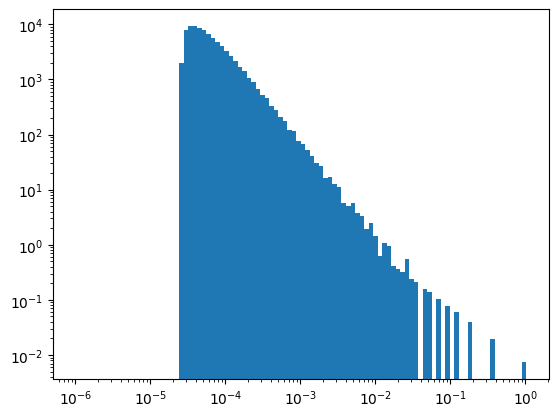

In [5]:
hist, bins = jnp.histogram(Khat_eigs[Khat_eigs > 0], bins=100)
logbins = np.logspace(-6,np.log10(bins[-1]),len(bins))
plt.hist(Khat_eigs, bins=logbins, density=True)
plt.xscale("log")
plt.yscale("log")

In [9]:
@jit
def newton_step_m(z,m):
    S_vec = D_vec / (D_vec * m - z)
    s = jnp.sum(S_vec)
    s2 = jnp.sum(S_vec ** 2)
    f = m * (1 + s/d) - 1
    f_prime = 1 + s/d - m/d * s2
    m -= f/f_prime

    return m

@jit
def newton_solve_m(x,ivals):
    m = 1
    for i in ivals:
        z = x + i*1.0j
        m = newton_step_m(z,m)
    R0 = 1/(D_vec*m-z)
    bR02b = jnp.sum(R0**2 * btilde**2)
    bR0b = jnp.sum(R0 * btilde**2)
    tr_R = jnp.sum(R0) - (tau**2 * bR02b)/(1+tau**2 * bR0b)
    limit_dist = 1/jnp.pi * jnp.imag(tr_R) / d

    return limit_dist

In [10]:
#Stieltjes inversion
# Next time try Newton

xvals = jnp.logspace(-6,1,num=1000)
ivals = jnp.logspace(0,-10,num=100)

limit_dist = []

for x in xvals:
   limit_dist.append(newton_solve_m(x,ivals).reshape(-1))

limit_dist = jnp.array(limit_dist)

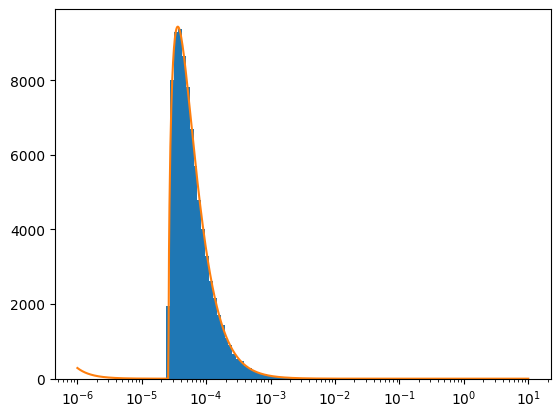

In [11]:
hist, bins = jnp.histogram(Khat_eigs, bins=100)
logbins = np.logspace(-6,np.log10(bins[-1]),len(bins))
plt.hist(Khat_eigs, bins=logbins, density=True)
plt.plot(xvals, limit_dist)
plt.xscale('log')
#plt.yscale('log')

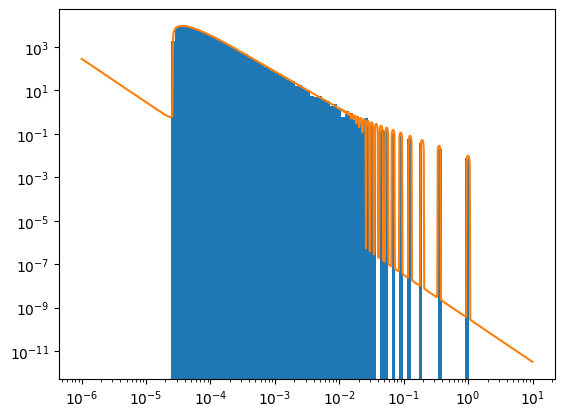

In [12]:
hist, bins = jnp.histogram(Khat_eigs, bins=100)
logbins = np.logspace(-6,np.log10(bins[-1]),len(bins))
plt.hist(Khat_eigs, bins=logbins, density=True)
plt.plot(xvals, limit_dist)
plt.xscale('log')
plt.yscale('log')

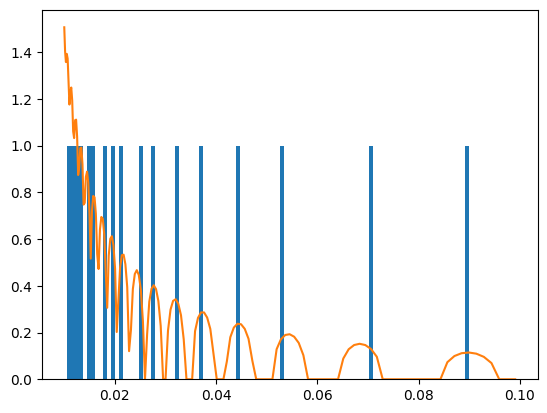

In [13]:
plt.hist(Khat_eigs[(Khat_eigs > 1e-2) * (Khat_eigs < 1e-1)], bins=100)
plt.plot(xvals[(xvals > 1e-2) * (xvals < 1e-1)], limit_dist[(xvals > 1e-2) * (xvals < 1e-1)])